# Zooplankton vs Control in the Arctic Ocean, using COPEPOD database (there is not seasonality in the copepod database though). 


In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob,os,subprocess
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

# input file

In [3]:
print('What is the new file? (new_file)')
new_file = input('')
print('What year? (year)')
year = input('')

What is the new file? (new_file)


 GNG595


What year? (year)


 20yrclim


In [4]:
carbon_molar_mass = 12.011 #g/mol 
cobalt_n_2_c = 106./16. 

# Regridded 

In [5]:
zoo3_inds = sorted(glob.glob('/glade/scratch/gabyn/'+new_file+'_20yrclim/remapgrid_'+new_file+'_zoo3C.*.nc', recursive=True))
zoo3_ds = xr.open_mfdataset(zoo3_inds,combine='by_coords')
zoo4_inds = sorted(glob.glob('/glade/scratch/gabyn/'+new_file+'_20yrclim/remapgrid_'+new_file+'_zoo4C.*.nc', recursive=True))
zoo4_ds = xr.open_mfdataset(zoo4_inds,combine='by_coords')
zoo5_inds = sorted(glob.glob('/glade/scratch/gabyn/'+new_file+'_20yrclim/remapgrid_'+new_file+'_zoo5C.*.nc', recursive=True))
zoo5_ds = xr.open_mfdataset(zoo5_inds,combine='by_coords')
zoo6_inds = sorted(glob.glob('/glade/scratch/gabyn/'+new_file+'_20yrclim/remapgrid_'+new_file+'_zoo6C.*.nc', recursive=True))
zoo6_ds = xr.open_mfdataset(zoo6_inds,combine='by_coords')

In [6]:
mesozooC_regrid = zoo3_ds.zoo3C+zoo4_ds.zoo4C+zoo5_ds.zoo5C+zoo6_ds.zoo6C #mmol/m^3
mesozooC_regrid = mesozooC_regrid.isel(z_t_150m=slice(None,10)).mean(dim='z_t_150m')* 12.011 #mg C/m^3

## Zooplankton Observations. 

In [7]:
cope_path = '/glade/u/home/jluo/work/obs/COPEPOD/data/'
cope_files = sorted(glob.glob(cope_path + 'copepod-2012__cmass-m0[1-9]-qtr.nc') + glob.glob(cope_path + 'copepod-2012__cmass-m1[0-2]-qtr.nc'))
dzt = xr.open_mfdataset(cope_files, combine='by_coords')
dzt = dzt.compute()

In [8]:
zratio_path = '/glade/work/jluo/obs/z-ratio/data/1deg_temp_variable/'
dz = xr.open_dataset(zratio_path + 'copepod-2012_zratio_m00.nc', decode_times=False)

In [9]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Mesozooplankton Observations

Text(0.5, 1.0, 'COPEPOD database, mesozooplankton biomass (mg C m$^{-3}$)')

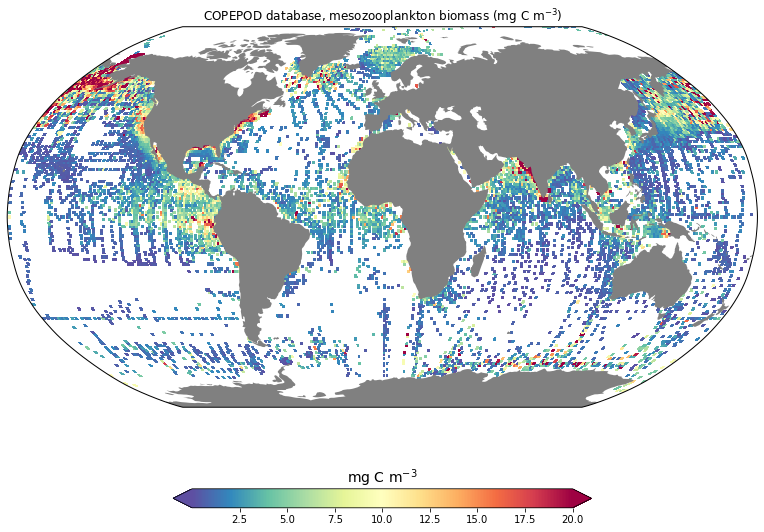

In [10]:
plt.figure(figsize=(15,10)) 
ax=plt.axes(projection=ccrs.Robinson(central_longitude=0.0)) 
cs=ax.pcolormesh(dz.lon.values, dz.lat.values, dz.carbon_biomass.isel(time=0).values, cmap='Spectral_r',transform=ccrs.PlateCarree(), vmax=20) 
cbar = plt.colorbar(cs, shrink=0.5, extend = 'both', orientation='horizontal')
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar.ax.set_title('mg C $m^{-3}$', fontsize = 14)
plt.title('COPEPOD database, mesozooplankton biomass (mg C m$^{-3}$)')

In [11]:
dz.carbon_biomass

<xarray.DataArray 'carbon_biomass' (time: 1, lat: 180, lon: 360)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) int64 0

## Mesozooplankton in the Arctic Ocean

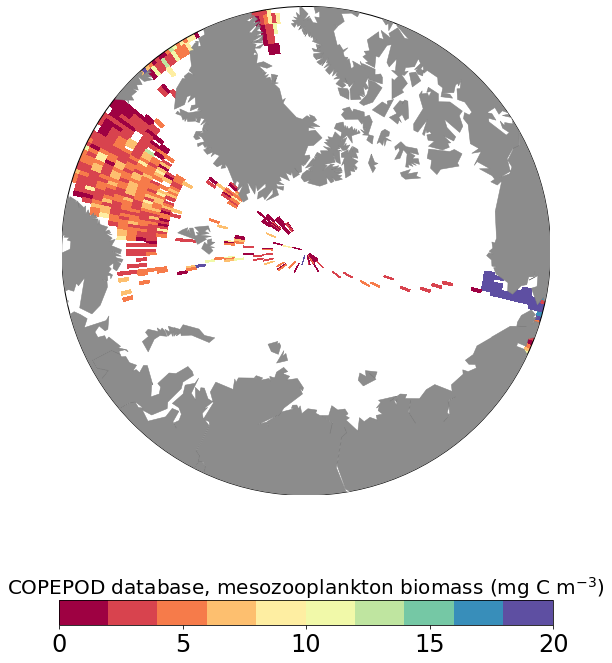

In [21]:
fig = plt.figure(figsize=(10, 10))

lat = dz.lat.values
ax = fig.add_subplot(1, 1, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
zoo, lon = add_cyclic_point(dz.carbon_biomass.isel(time=0).values, coord=dz.lon.values, axis=1)
x, y = m(*np.meshgrid(lon,lat))
cf = m.pcolormesh(x,y,zoo,shading='flat',cmap=plt.cm.get_cmap('Spectral', 10),vmin = 0, vmax=20) 
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
cb = plt.colorbar(cf, ticks=[0,5,10,15,20],shrink=0.75, orientation='horizontal')
cb.ax.set_xticklabels(['0','5','10','15','20'])
cb.ax.set_title('COPEPOD database, mesozooplankton biomass (mg C m$^{-3}$)', fontsize = 20)
cb.ax.tick_params(labelsize=24)

fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/COPEPOD_mesozooplankton_AO_'+year+'_year.png', dpi=600, bbox_inches='tight')

### Now compare point by point with this dataset

In [13]:
obs_meso = dz.carbon_biomass.isel(time=0).values

In [14]:
mesozooC_regrid = zoo3_ds.zoo3C+zoo4_ds.zoo4C+zoo5_ds.zoo5C+zoo6_ds.zoo6C #mmol/m^3
mesozooC_regrid = mesozooC_regrid.isel(z_t_150m=slice(None,10)).mean(dim='z_t_150m')* 12.011 #mg C/m^3

In [15]:
# this finds the summer in the Northern Hemisphere, and the summer in the Southern Hemisphere 
N_hem = np.nanmean(mesozooC_regrid[5:8,0:90,:],axis=0)
S_hem = np.nanmean(mesozooC_regrid[[0,1,-1],90:180,:],axis=0)
model_meso = np.concatenate((N_hem, S_hem), axis=0)

In [16]:
ind_data = np.isnan(obs_meso) # this finds the values that are NaN in the observations

In [17]:
model_meso[ind_data] = np.nan # this makes the values that are NaN on the obs to NaN in SPECTRA

Text(0.5, 1.0, 'mg C $m^{-3}$')

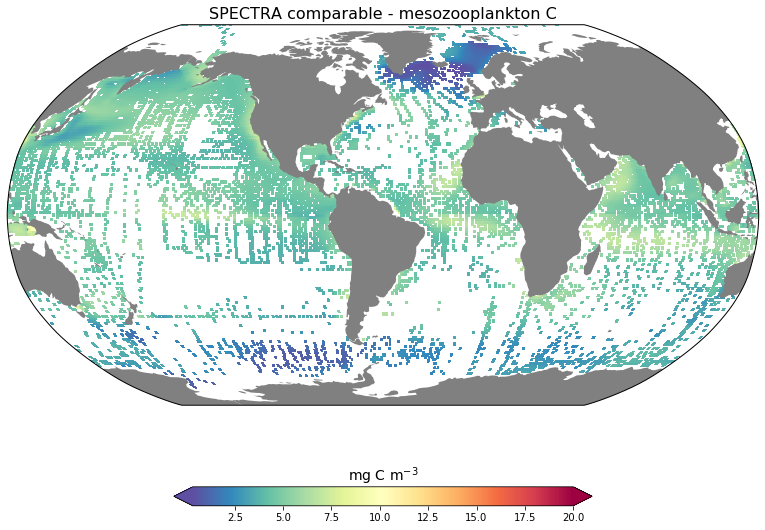

In [18]:
fig = plt.figure(figsize=(15, 10))
lat = dz.lat

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
phyto, lon = add_cyclic_point(model_meso, coord=dz.lon, axis=1)
cf = ax.pcolor(lon, lat, phyto, cmap='Spectral_r',transform=ccrs.PlateCarree(), vmax = 20)
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf, shrink=0.5, extend = 'both', orientation='horizontal')
ax.set_title('SPECTRA comparable - mesozooplankton C', fontsize =16)
cbar.ax.set_title('mg C $m^{-3}$', fontsize = 14)

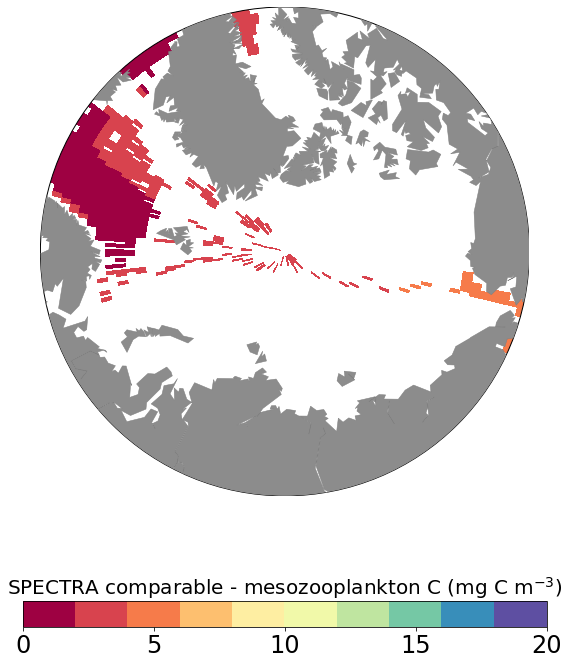

In [20]:
fig = plt.figure(figsize=(10, 10))

lat = dz.lat.values
ax = fig.add_subplot(1, 1, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
zoo, lon = add_cyclic_point(model_meso, coord=dz.lon.values, axis=1)
x, y = m(*np.meshgrid(lon,lat))
cf = m.pcolormesh(x,y,zoo,shading='flat',cmap=plt.cm.get_cmap('Spectral', 10),vmin = 0, vmax=20) 
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
cb = plt.colorbar(cf, ticks=[0,5,10,15,20],shrink=0.75, orientation='horizontal')
cb.ax.set_xticklabels(['0','5','10','15','20'])
cb.ax.set_title('SPECTRA comparable - mesozooplankton C (mg C m$^{-3}$)', fontsize = 20)
cb.ax.tick_params(labelsize=24)

fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/SPECTRA_mesozooplankton_AO_'+year+'_year.png', dpi=600, bbox_inches='tight')